#                                  比特币交易策略初试（多因子LSTM最简模型）

## 比特币涨跌原因总结：

### 1.NVT Ratio，即Network Value to Transactions Ratio的缩写
     NVT比率是目前看到的认可度较高的比特币估值模型。
     NVT比率（网络价值与交易比率）类似于股票市场中使用的PE比率。
     当比特币的NVT高时，表明其网络估值超过其支付网络上传输的价值，可能为一个不可持续的泡沫。
### 2.比特币关注度：政策，社会动荡（避险），舆论
### 3.比特币开采难度：矿机价格，算力，电费，剩余可开采币（总量有限为2100万个）
### 4.每时刻价格受历史价格影响
### 5.总量少，对于大宗持有者来说，退出进来都会改变这个环境，难以在波动中获利
### 6.每日交易笔数限制：区块大小、分叉等
### 7.交易所bug
### 8.其它因子：https://data.bitcoinity.org/bitcoin/block_size_votes/7d?c=block_size_votes&t=b
***

## 模型思路： 
1.预测价格：输入过去10天各因子序列（本项目因子包括比特币每天价格，每天交易量，每天NVT比率），输出将来2天的比特币收盘价。

2.买卖信号：资产分2份，2天为一周期，每天都判断，如2天后的收盘价大于当前价则买一份，买信号发出2天后必卖一份，策略偏保守，最大回撤小，收益小。

3.仓位： 根据信号计算应该持有仓位，要加仓则买，要减仓则卖。

4.回测：不考虑滑点、手续费、假设环境不会因自己操作变化，计算资金曲线，计算最大回撤；
***

## 读取比特币历史数据

数据来源：https://github.com/yan-wong/BitcoinPriceHistoryInChina/blob/master/data/okcoin/daily_price_btc_cny.csv


In [58]:
import sys
import pandas as pd
df = pd.read_csv("./daily_price_btc_cny.csv",sep = ',')
header = ['date','open','high','low','close','volume']
df = df[header]
df['date'] = pd.to_datetime(df['date'])
df.set_index(['date'], inplace = True, drop=True) 
df.head()

,open,high,low,close,volume
date,,,,,
2013-09-01,806.37,815.0,803.20,811.42,84.2276
2013-09-02,810.60,816.7,801.00,811.00,317.1206
2013-09-03,809.70,812.0,797.90,801.37,304.0173
2013-09-04,801.00,802.2,797.00,798.20,308.5300
2013-09-05,800.00,802.0,663.27,752.30,1016.1104


## 读取比特币NVT Ratio

数据来源：https://docs.google.com/spreadsheets/d/1xLTC4oaDyI-aqbc_lehGUspGDRLb-q6s7SN4nTdGluY/edit#gid=1383584969

NVT介绍：https://woobull.com/introducing-nvt-ratio-bitcoins-pe-ratio-use-it-to-detect-bubbles/

In [59]:
import sys
import pandas as pd
df_nvt = pd.read_csv("./btc_nvt.csv",sep = ',')
df_nvt.set_index(['date'], inplace = True, drop=False)
df_nvt = df_nvt.loc['9/1/2013': '9/18/2017']
df_nvt['date'] = pd.to_datetime(df_nvt['date'])
df_nvt.set_index(['date'], inplace = True, drop=True)
df_nvt.convert_objects(convert_numeric=True)
header = ['Network Value','Txn Value', 'NVT']
df_nvt = df_nvt[header]
n_ma = 5
df_nvt['ma_'+str(n_ma)] = df_nvt['NVT'].rolling(n_ma, min_periods=1).mean()
# print(df_nvt.dtypes)
df_nvt.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


,Network Value,Txn Value,NVT,ma_5
date,,,,
2013-09-01,1522502783,19292550,78.916617,78.916617
2013-09-03,1519566392,21059813,72.154790,75.535704
2013-09-05,1451422408,25503578,56.910540,69.327316
2013-09-07,1401657885,13811249,101.486686,77.367158
2013-09-09,1420313587,15359356,92.472210,80.388169


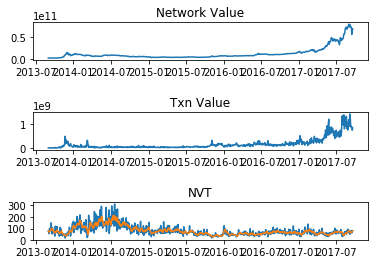

In [60]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# print(df_nvt.values, df_nvt.values[:,2].shape)
plt.figure()
plt.subplot(5,1,1)
plt.title('Network Value')
plt.plot(df_nvt.index, df_nvt.values[:,0].reshape(-1))
plt.subplot(5,1,3)
plt.title('Txn Value')
plt.plot(df_nvt.index, df_nvt.values[:,1].reshape(-1))
plt.subplot(5,1,5)
plt.title('NVT')
plt.plot(df_nvt.index, df_nvt.values[:,2].reshape(-1))
plt.plot(df_nvt.index, df_nvt.values[:,3].reshape(-1))
plt.show()

## 合并数据

In [61]:
df['NVT'] = df_nvt['NVT']
df['NVT'] = df['NVT'].fillna(method='ffill')
df.to_csv('input.csv')
df.head()

,open,high,low,close,volume,NVT
date,,,,,,
2013-09-01,806.37,815.0,803.20,811.42,84.2276,78.916617
2013-09-02,810.60,816.7,801.00,811.00,317.1206,78.916617
2013-09-03,809.70,812.0,797.90,801.37,304.0173,72.154790
2013-09-04,801.00,802.2,797.00,798.20,308.5300,72.154790
2013-09-05,800.00,802.0,663.27,752.30,1016.1104,56.910540


In [62]:
import matplotlib.pyplot as plt
from pandas import read_csv
import numpy as np
%matplotlib inline
df = read_csv('input.csv')
df.set_index(['date'], inplace = True, drop=True) 
list_feature = list(df.columns)
print(list_feature)
print(df.head())
print(df.tail())

['open', 'high', 'low', 'close', 'volume', 'NVT']
              open   high     low   close     volume        NVT
date                                                           
2013-09-01  806.37  815.0  803.20  811.42    84.2276  78.916617
2013-09-02  810.60  816.7  801.00  811.00   317.1206  78.916617
2013-09-03  809.70  812.0  797.90  801.37   304.0173  72.154790
2013-09-04  801.00  802.2  797.00  798.20   308.5300  72.154790
2013-09-05  800.00  802.0  663.27  752.30  1016.1104  56.910540
                open      high       low     close      volume        NVT
date                                                                     
2017-09-15  21385.90  21750.00  16827.00  20901.00  49730.3098  61.810605
2017-09-16  20924.95  22179.98  18231.24  19319.90  30077.2688  82.787702
2017-09-17  19319.90  20310.00  18900.00  19751.00  22935.9674  82.787702
2017-09-18  19751.00  22188.00  19400.00  21989.77  13457.0023  80.903514
2017-09-19  21988.00  23620.00  21300.00  22887.15   5859.

In [63]:
# plt.figure()
# for n_col, str_col in enumerate(df.columns):
#     plt.subplot(len(df.columns)*3-1,1,1+(n_col*3))
#     plt.title(str_col, y=0.5, loc='right')
#     plt.plot(df.index, df.values[:,n_col].reshape(-1))
# plt.show()

## 多因子LSTM预测模型

### 特征归一化

In [64]:
from sklearn.preprocessing import MinMaxScaler
# ensure all data is float
values = df
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)
scaled

(1480, 6)


array([[3.00070651e-03, 2.62508698e-03, 1.04009768e-02, 3.16813033e-03,
        0.00000000e+00, 2.08509842e-01],
       [3.14094437e-03, 2.67885420e-03, 1.03255076e-02, 3.15420650e-03,
        4.64147406e-05, 2.08509842e-01],
       [3.11110760e-03, 2.53020431e-03, 1.02191660e-02, 2.83493996e-03,
        4.38032995e-05, 1.85245361e-01],
       ...,
       [6.16785539e-01, 6.19204251e-01, 6.31193817e-01, 6.31077919e-01,
        4.55426965e-03, 2.21828554e-01],
       [6.31077919e-01, 6.78600797e-01, 6.48345823e-01, 7.05300541e-01,
        2.66514596e-03, 2.15345870e-01],
       [7.05241876e-01, 7.23891454e-01, 7.13523445e-01, 7.35051688e-01,
        1.15101949e-03, 2.15345870e-01]])

### 将数据集转换为监督学习问题

In [65]:
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, list_feature, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(list_feature[j]+'(t-%d)' % (i)) for j in range(n_vars)] #待优化
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(list_feature[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(list_feature[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_in = 3  #用过去多少天的特征作为输入
n_out = 2  #预测未来多少天价格
# frame as supervised learning
reframed = series_to_supervised(scaled, list_feature, n_in, n_out)
print(reframed.shape)
reframed.head()

(1476, 30)


,open(t-3),high(t-3),low(t-3),close(t-3),volume(t-3),NVT(t-3),open(t-2),high(t-2),low(t-2),close(t-2),...,low(t),close(t),volume(t),NVT(t),open(t+1),high(t+1),low(t+1),close(t+1),volume(t+1),NVT(t+1)
3,0.003001,0.002625,0.010401,0.003168,0.000000,0.208510,0.003141,0.002679,0.010326,0.003154,...,0.010188,0.002730,0.000045,0.185245,0.002790,0.002214,0.005601,0.001208,0.000186,0.132797
4,0.003141,0.002679,0.010326,0.003154,0.000046,0.208510,0.003111,0.002530,0.010219,0.002835,...,0.005601,0.001208,0.000186,0.132797,0.001208,0.000642,0.007672,0.000800,0.000086,0.132797
5,0.003111,0.002530,0.010219,0.002835,0.000044,0.185245,0.002823,0.002220,0.010188,0.002730,...,0.007672,0.000800,0.000086,0.132797,0.000774,0.000266,0.006754,0.000303,0.000189,0.286164
6,0.002823,0.002220,0.010188,0.002730,0.000045,0.185245,0.002790,0.002214,0.005601,0.001208,...,0.006754,0.000303,0.000189,0.286164,0.000329,0.000000,0.007405,0.000000,0.000122,0.286164
7,0.002790,0.002214,0.005601,0.001208,0.000186,0.132797,0.001208,0.000642,0.007672,0.000800,...,0.007405,0.000000,0.000122,0.286164,0.000000,0.001172,0.007266,0.001306,0.000136,0.255149


### 拆分为输入矩阵和输出矩阵

In [66]:
print(reframed.columns)
list_use_feature = []
for j in range(len(list_feature)):
#     list_use_feature.append(list_feature[j]+'(t)')
    for i in range(n_in):
        list_use_feature.append(list_feature[j]+'(t-%d)' % (i+1))
    
X = reframed[list_use_feature]
print(X.columns)

list_use_result = []
list_use_result.append('close(t)')
for i in range(n_out-1):
    list_use_result.append('close(t+%d)' % (i+1))
Y = reframed[list_use_result]
print(Y.columns)

Index(['open(t-3)', 'high(t-3)', 'low(t-3)', 'close(t-3)', 'volume(t-3)',
       'NVT(t-3)', 'open(t-2)', 'high(t-2)', 'low(t-2)', 'close(t-2)',
       'volume(t-2)', 'NVT(t-2)', 'open(t-1)', 'high(t-1)', 'low(t-1)',
       'close(t-1)', 'volume(t-1)', 'NVT(t-1)', 'open(t)', 'high(t)', 'low(t)',
       'close(t)', 'volume(t)', 'NVT(t)', 'open(t+1)', 'high(t+1)', 'low(t+1)',
       'close(t+1)', 'volume(t+1)', 'NVT(t+1)'],
      dtype='object')
Index(['open(t-1)', 'open(t-2)', 'open(t-3)', 'high(t-1)', 'high(t-2)',
       'high(t-3)', 'low(t-1)', 'low(t-2)', 'low(t-3)', 'close(t-1)',
       'close(t-2)', 'close(t-3)', 'volume(t-1)', 'volume(t-2)', 'volume(t-3)',
       'NVT(t-1)', 'NVT(t-2)', 'NVT(t-3)'],
      dtype='object')
Index(['close(t)', 'close(t+1)'], dtype='object')


### 拆分为训练集和测试集（最好有验证集来网格搜素或贝叶斯搜素超参数，这里采用最简单方式）

In [67]:
print(X.shape, Y.shape)
type(X)

(1476, 18) (1476, 2)


pandas.core.frame.DataFrame

In [68]:
X = X.values
Y = Y.values
n_train_days = int(X.shape[0]/3)
print(n_train_days)
train_X, train_Y = X[:n_train_days, :], Y[:n_train_days, :]
test_X, test_Y = X[n_train_days:, :], Y[n_train_days:, :]

# reshape input to be 3D [batchs, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# train_Y = train_Y.reshape((train_Y.shape[0], 1, train_Y.shape[1]))
# test_Y = test_Y.reshape((test_Y.shape[0], 1, test_Y.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

492
(492, 1, 18) (492, 2) (984, 1, 18) (984, 2)


### 构建及训练LSTM模型

Train on 492 samples, validate on 984 samples
Epoch 1/50
 - 2s - loss: 0.0755 - val_loss: 0.1377
Epoch 2/50
 - 0s - loss: 0.0432 - val_loss: 0.1078
Epoch 3/50
 - 0s - loss: 0.0287 - val_loss: 0.0947
Epoch 4/50
 - 0s - loss: 0.0285 - val_loss: 0.0893
Epoch 5/50
 - 0s - loss: 0.0250 - val_loss: 0.0868
Epoch 6/50
 - 0s - loss: 0.0223 - val_loss: 0.0846
Epoch 7/50
 - 0s - loss: 0.0220 - val_loss: 0.0802
Epoch 8/50
 - 0s - loss: 0.0209 - val_loss: 0.0737
Epoch 9/50
 - 0s - loss: 0.0194 - val_loss: 0.0673
Epoch 10/50
 - 0s - loss: 0.0178 - val_loss: 0.0614
Epoch 11/50
 - 0s - loss: 0.0163 - val_loss: 0.0559
Epoch 12/50
 - 0s - loss: 0.0150 - val_loss: 0.0501
Epoch 13/50
 - 0s - loss: 0.0137 - val_loss: 0.0440
Epoch 14/50
 - 0s - loss: 0.0123 - val_loss: 0.0379
Epoch 15/50
 - 0s - loss: 0.0110 - val_loss: 0.0321
Epoch 16/50
 - 0s - loss: 0.0098 - val_loss: 0.0269
Epoch 17/50
 - 0s - loss: 0.0087 - val_loss: 0.0222
Epoch 18/50
 - 0s - loss: 0.0078 - val_loss: 0.0192
Epoch 19/50
 - 0s - loss: 0

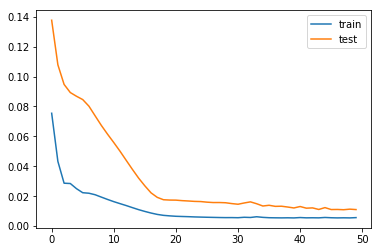

In [69]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_Y.shape[1]))
# model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_Y[:,:,0], epochs=50, batch_size=72, validation_data=(test_X, test_Y[:,:,0]), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [70]:
Yhat = model.predict(test_X)

### 评估模型
注意：close(t)[i+1] 本就不应该等于 close(t+1)[i]， 因变量不同 

预测未来值较多时，应该改为for循环

In [71]:
from numpy import concatenate
import copy
# make a prediction
inv_Yhat = copy.deepcopy(Yhat)
print('close(t)', inv_Yhat[:,0].reshape(-1)[:10])
print('close(t+1)', inv_Yhat[:,1].reshape(-1)[:10])
print(Yhat.shape)
print(scaled[n_train_days:, :].shape)
inv_Yhat0 = concatenate((scaled[n_in:-n_out+1, :3][n_train_days:,:],
                         Yhat[:,:1], 
                         scaled[n_in:-n_out+1, 4:][n_train_days:,:]), axis=1)
inv_Yhat0 = scaler.inverse_transform(inv_Yhat0)
inv_Yhat0 = inv_Yhat0[:,3]

inv_Yhat1 = concatenate((scaled[n_in:-n_out+1, :3][n_train_days:,:],
                         Yhat[:,1:], 
                         scaled[n_in:-n_out+1, 4:][n_train_days:,:]), axis=1)
inv_Yhat1 = scaler.inverse_transform(inv_Yhat1)
inv_Yhat1 = inv_Yhat1[:,3]

predictiony0 = inv_Yhat0.reshape(-1)
predictiony1 = inv_Yhat1.reshape(-1)
originaly = values['close'].values[n_in:-n_out+1][n_train_days:]
x = values.index[n_in:-n_out+1][n_train_days:]
print(len(predictiony0), predictiony0[:10])
print(len(predictiony1), predictiony1[:10])
print(len(originaly), originaly[:10])
print(len(x), x[:10]) 
print(values.index)

close(t) [0.03183591 0.03183633 0.03147676 0.03049881 0.03038601 0.02865454
 0.02409944 0.02084251 0.01833283 0.01701074]
close(t+1) [0.03588778 0.03658395 0.03621344 0.03533049 0.03489287 0.03226837
 0.02757681 0.02536568 0.02303653 0.02182248]
(984, 2)
(988, 6)
984 [1676.1232337  1676.13593101 1665.29040736 1635.79242583 1632.39022146
 1580.16411471 1442.76907257 1344.53039351 1268.83117788 1228.95325939]
984 [1798.33943063 1819.33808136 1808.1624277  1781.53010499 1768.33018581
 1689.16752659 1547.65647789 1480.96257517 1410.70865067 1374.08922099]
984 [1739.23 1682.02 1645.   1679.2  1441.1  1181.01 1289.   1269.95 1206.69
 1295.  ]
984 Index(['2015-01-09', '2015-01-10', '2015-01-11', '2015-01-12', '2015-01-13',
       '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18'],
      dtype='object', name='date')
Index(['2013-09-01', '2013-09-02', '2013-09-03', '2013-09-04', '2013-09-05',
       '2013-09-06', '2013-09-07', '2013-09-08', '2013-09-09', '2013-09-10',
       

### 预测基本准确

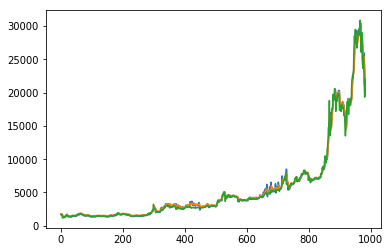

In [72]:
%matplotlib inline 
plt.figure()
# plt.subplot(5,1,1)
# plt.plot(x, predictiony0)
plt.plot(predictiony0)
# plt.subplot(5,1,3)
plt.plot(predictiony1)
# plt.subplot(5,1,5)
plt.plot(originaly)
plt.show()

### 计算信号 (只计算测试集)
资产分2份，2天为一周期，每天都判断，如2天后的收盘价大于当前价则买一份，买信号发出2天后必卖一份，策略偏保守，最大回撤小，收益小。

In [73]:
dataset = {'date':x,
           'close(t-1)':originaly,
       'close(t)':predictiony0,
       'close(t+1)':predictiony1}
df = DataFrame(dataset)
# df.set_index(['date'], inplace = True, drop=True) 
df['close(t+1)-close(t-1)'] = df['close(t+1)'] - df['close(t-1)']
df['isbuy'] = df['close(t+1)-close(t-1)'] > 0
df['issell'] = df['isbuy'].shift(2) #n_out=2
df['issell'].fillna(value= False, inplace=True)
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell
0,2015-01-09,1739.229980,1676.123234,1798.339431,59.109450,True,False
1,2015-01-10,1682.020020,1676.135931,1819.338081,137.318062,True,False
2,2015-01-11,1645.000000,1665.290407,1808.162428,163.162428,True,True
3,2015-01-12,1679.199951,1635.792426,1781.530105,102.330154,True,True
4,2015-01-13,1441.099976,1632.390221,1768.330186,327.230210,True,True
5,2015-01-14,1181.010010,1580.164115,1689.167527,508.157517,True,True
6,2015-01-15,1289.000000,1442.769073,1547.656478,258.656478,True,True
7,2015-01-16,1269.949951,1344.530394,1480.962575,211.012624,True,True
8,2015-01-17,1206.689941,1268.831178,1410.708651,204.018709,True,True
9,2015-01-18,1295.000000,1228.953259,1374.089221,79.089221,True,True


### 计算仓位

In [74]:
initlocation = 0 #初始仓位为0
initUS = 2 #初始美元现金为2
maxlocation = 2 #满仓为2
def function(isbuy, issell):
    if issell and (not isbuy): return -1
    if isbuy and issell: return 0
    if (not isbuy) and (not issell): return 0
    if isbuy and (not issell): return 1

df['location action'] = df.apply(lambda x: function(x.isbuy, x.issell), axis = 1)
df['location status'] = df['location action'].expanding().sum()
df['location status'] = df['location status'] / df['location status'].max()
df

,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell,location action,location status
0,2015-01-09,1739.229980,1676.123234,1798.339431,59.109450,True,False,1,0.5
1,2015-01-10,1682.020020,1676.135931,1819.338081,137.318062,True,False,1,1.0
2,2015-01-11,1645.000000,1665.290407,1808.162428,163.162428,True,True,0,1.0
3,2015-01-12,1679.199951,1635.792426,1781.530105,102.330154,True,True,0,1.0
4,2015-01-13,1441.099976,1632.390221,1768.330186,327.230210,True,True,0,1.0
5,2015-01-14,1181.010010,1580.164115,1689.167527,508.157517,True,True,0,1.0
6,2015-01-15,1289.000000,1442.769073,1547.656478,258.656478,True,True,0,1.0
7,2015-01-16,1269.949951,1344.530394,1480.962575,211.012624,True,True,0,1.0
8,2015-01-17,1206.689941,1268.831178,1410.708651,204.018709,True,True,0,1.0
9,2015-01-18,1295.000000,1228.953259,1374.089221,79.089221,True,True,0,1.0


### 计算资金曲线

In [75]:
df['cycle growth rate'] = df['close(t-1)'].rolling(2).apply(lambda x: x[1]-x[0])
df['cycle growth rate'] = df['cycle growth rate'].shift(-1)
df['cycle growth rate'].fillna(value=0, inplace=True)
df['cycle growth rate'] = df['cycle growth rate'] /  df['close(t-1)']  #close(t-1)为真实价格，close(t)，close(t+1)为预测价格
df['Asset cycle growth rate'] = df['location status'] * df['cycle growth rate']
df['cycle growth rate'] = df['cycle growth rate'].shift(1)
df['cycle growth rate'].fillna(value=0, inplace=True)
df['Asset cycle growth rate'] = df['Asset cycle growth rate'].shift(1)
df['Asset cycle growth rate'].fillna(value=0, inplace=True)
df['Asset cycle growth rate'] = df['Asset cycle growth rate'] + 1
df['Asset growth rate'] = df['Asset cycle growth rate'].cumprod()
df['BTC growth rate'] = (df['cycle growth rate']+1).cumprod()
df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


,date,close(t-1),close(t),close(t+1),close(t+1)-close(t-1),isbuy,issell,location action,location status,cycle growth rate,Asset cycle growth rate,Asset growth rate,BTC growth rate
0,2015-01-09,1739.229980,1676.123234,1798.339431,59.109450,True,False,1,0.5,0.000000,1.000000,1.000000,1.000000
1,2015-01-10,1682.020020,1676.135931,1819.338081,137.318062,True,False,1,1.0,-0.032894,0.983553,0.983553,0.967106
2,2015-01-11,1645.000000,1665.290407,1808.162428,163.162428,True,True,0,1.0,-0.022009,0.977991,0.961906,0.945821
3,2015-01-12,1679.199951,1635.792426,1781.530105,102.330154,True,True,0,1.0,0.020790,1.020790,0.981904,0.965485
4,2015-01-13,1441.099976,1632.390221,1768.330186,327.230210,True,True,0,1.0,-0.141794,0.858206,0.842676,0.828585
5,2015-01-14,1181.010010,1580.164115,1689.167527,508.157517,True,True,0,1.0,-0.180480,0.819520,0.690590,0.679042
6,2015-01-15,1289.000000,1442.769073,1547.656478,258.656478,True,True,0,1.0,0.091439,1.091439,0.753737,0.741133
7,2015-01-16,1269.949951,1344.530394,1480.962575,211.012624,True,True,0,1.0,-0.014779,0.985221,0.742597,0.730179
8,2015-01-17,1206.689941,1268.831178,1410.708651,204.018709,True,True,0,1.0,-0.049813,0.950187,0.705606,0.693807
9,2015-01-18,1295.000000,1228.953259,1374.089221,79.089221,True,True,0,1.0,0.073184,1.073184,0.757245,0.744582


### 绘制资金曲线

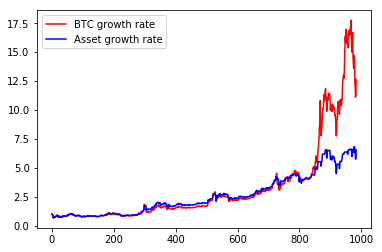

In [76]:
%matplotlib inline 
plt.figure()
# plt.subplot(3,1,1)
plt.plot(df['BTC growth rate'].values.reshape(-1), 'r', label='BTC growth rate')
plt.plot(df['Asset growth rate'].values.reshape(-1), 'b', label='Asset growth rate')

plt.legend()
plt.show()
# print(df['date'].head())
# print(df['date'].tail())

## 总结：
### 此策略会减少最大回撤，减少波动，比较稳健；
### 收益率与LSTM预测的准确率直接相关，应该加入更多因子，及设置更合适的超参
### 此模型同样的数据收益率存在随机性
### 试用集成学习等模型